In [146]:
from power_planner.utils.utils import get_donut_vals, get_half_donut, get_distance_surface, bresenham_line, rescale, get_lg_donut, angle, normalize
from power_planner.plotting import plot_path, plot_path_costs
from power_planner.utils.utils_constraints import ConstraintUtils
import numpy as np
from graph_tool.all import Graph, shortest_path,load_graph, find_edge, remove_labeled_edges
import matplotlib.pyplot as plt
import os
import pickle
import time

In [215]:
instance_path = "/Users/ninawiedemann/Downloads/tifs_new/data_dump_5.dat"
with open(instance_path, "rb") as infile:
    data = pickle.load(infile)
(instance, instance_corr, start_inds, dest_inds) = data.data

In [216]:
FACTOR_ALL = 2
test_example = rescale(np.sum(instance, 0), FACTOR_ALL)

<function matplotlib.pyplot.show(*args, **kw)>

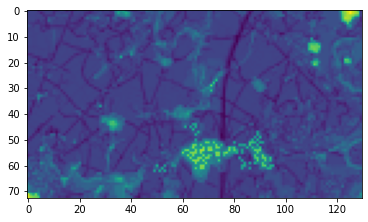

In [217]:
plt.imshow(test_example)
plt.show

In [218]:
min_dist = 3
max_dist = 5
weights = [0.5,0.5]
start_inds = start_inds//FACTOR_ALL
dest_inds = dest_inds//FACTOR_ALL
test_example = normalize(test_example)+0.1

In [220]:
def shift_surface(costs, shift, fill_val = np.inf):
    """
    Shifts a numpy array and pads with zeros
    :param costs: 2-dim numpy array
    :param shift: tuple of shift in x and y direction
    BUT: ONLY WORKS FOR (+,+) or (+,-) shift tuples
    :returns shifted array of same size
    """
    rolled_costs = np.roll(costs, shift, axis=(0, 1))
    if shift[0] >= 0:
        rolled_costs[:shift[0], :] = fill_val
    else:
        rolled_costs[shift[0]:, :] = fill_val
    if shift[1] >= 0:
        rolled_costs[:, :shift[1]] = fill_val
    else:
        rolled_costs[:, shift[1]:] = fill_val
    return rolled_costs

def compute_angles_manually(path):
    ang_out = [0]
    for p in range(len(path)-2):
        vec1 = path[p+1]-path[p]
        vec2 = path[p+2]-path[p+1]
        print( path[p+2],  path[p+1])
        ang_out.append(round(angle(vec1, vec2)/(3*np.pi/4), 2))
        print(ang_out[-1])
    ang_out.append(0)
    return ang_out

In [476]:
def compute_dists(n_iters, shifts, test_example, start_inds, dest_inds, weights = [0.5, 1]):
    # weights = [0.5,0.5]
    min_angle= np.pi / 4 # TODO

    fill_val = np.inf
    # one iteration
    # for i in range(len(shifts)):
    x_len, y_len = test_example.shape
    angle_weight, resistance_weight = tuple(np.array(weights)/np.sum(weights))
    print(angle_weight, resistance_weight)
    dists = np.zeros((len(shifts), x_len, y_len))
    dists += fill_val
    dists[:, start_inds[0], start_inds[1]] = test_example[start_inds[0], start_inds[1]]
    dists_argmin = np.zeros(dists.shape)
    # precompute angles
    angles_all = np.zeros((len(shifts), len(shifts)))
    for i in range(len(shifts)):
        angles_all[i] = [angle(s, shifts[i]) for s in shifts]
    angles_all = angles_all/min_angle
    angles_all[angles_all>1] = np.inf
    # print(angles_all)
    times_cs = []
    times_together = []
    times_chosen = []
    for j in range(n_iters):
        for i in range(len(shifts)): # 10,11): # 
            # i = 10
            # compute angle from the sorted neighbor list to the new edge
            # immer plus das minimum
            curr_shift = shifts[i]

            angles = angles_all[i]
            
            ticcs = time.time()
            # shift dists by this shift
            # todo: avoid swaping dimenions each time
            cost_switched = np.moveaxis(dists, 0, -1)
            # shift by shift
            costs_shifted = shift_surface(
                cost_switched, curr_shift
            )
            times_cs.append(time.time() - ticcs)
            # costs_shifted[costs_shifted==0] = fill_val

            # POSSIBLE BUT not necessary!
            # test_shifted = shift_surface(
            #     test_example.copy(), curr_shift, fill_val=0
            # )
            # norm_angle = angles/min_angle # np.max(angles)
            # norm_angle[norm_angle>min_angle] = np.inf
            # norm_angle>1 --> np.inf
            
            # costs_shifted = np.moveaxis(costs_shifted, -1, 0)
            together = np.zeros(costs_shifted.shape)
            # for k in range(len(shifts)):
            #     for l in range(x_len):
            #         for m in range(y_len):
            #             together[k,l,m] = costs_shifted[k,l,m] + angles[k] * angle_weight + test_example[l,m]* resistance_weight
            tic_together = time.time()           
            angle_cost = angle_weight *  angles
            together = np.moveaxis(costs_shifted + angle_cost, -1, 0) + test_example * resistance_weight
            # 28 x 10 x 10 + 28 angles + 10 x 10
            times_together.append(time.time() - tic_together)
            
            tic_chosen = time.time()
            weighted_costs_shifted = np.min(together, axis=0)
            
            # if j==8 and i==16:
            #     print(angle_cost)
            #     print(np.argmin(together, axis=0)[16,70])
            #     print(weighted_costs_shifted[16, 70])
            # 

            concat = np.array([dists[i], weighted_costs_shifted])
            
            # temp = dists_argmin[i]
            # print(temp.shape)
            # get spots that are actually updated
            changed_ones = np.argmin(concat, axis=0)
            # get argmin for each edge --> remember where the value on this edge came from
            argmin_together = np.argmin(together, axis=0)
            ## FOR LOOP SOLUTION
            # for m in range(len(temp)):
            #     for n in range(len(temp[0])):
            #         if changed_ones[m,n]:
            #             dists_argmin[i,m,n] = argmin_together[m,n]
            ## TEMP SOLUTION:
            # temp[changed_ones>0] = argmin_together[changed_ones>0]
            # dists_argmin[i] = temp
            dists_argmin[i, changed_ones>0] = argmin_together[changed_ones>0]
            times_chosen = time.time() - tic_chosen

            dists[i] = np.min(concat, axis=0)
            # print("-------------")
    assert(np.all(dists_argmin<np.inf))
    print(np.mean(times_cs), np.mean(times_together), np.mean(times_chosen))
    print("opt", np.min(dists[:, dest_inds[0], dest_inds[1]]))
    
    return dists, dists_argmin

def get_path_from_dists(dists, dists_argmin, start_inds, dest_inds, test_example):
    if not np.any(dists[:, dest_inds[0], dest_inds[1]] < np.inf):
        raise RuntimeWarning("empty path")
        return [], []
    curr_point = dest_inds
    my_path = [dest_inds]
    path_costs = [test_example[dest_inds[0], dest_inds[1]]]
    # print(test_example[dest_inds[0], dest_inds[1]])
    min_shift = np.argmin(dists[:, dest_inds[0], dest_inds[1]])
    while np.any(curr_point - start_inds):
        # min_dist = np.argmin(dists[:, curr_point[0], curr_point[1]])
        new_point = curr_point - shifts[int(min_shift)]
        min_shift = dists_argmin[int(min_shift), curr_point[0], curr_point[1]]
        # print(new_point)
        # print(test_example[new_point[0], new_point[1]])
        path_costs.append(test_example[new_point[0], new_point[1]])
        my_path.append(new_point)
        curr_point = new_point
    return my_path, path_costs

# def my_path_computation(n_iters, shifts, test_example, start_inds, dest_inds, weights = [0.5, 1]):
shifts_ba = get_half_donut(3,5, start_inds-dest_inds, angle_max = 0.5*np.pi)
shifts_ab = get_half_donut(3,5, dest_inds-start_inds, angle_max = 0.5*np.pi)
dists_ba, dists_argmin_ba = compute_dists(50, shifts_ba, test_example, dest_inds, start_inds, weights = [0.1,0.9])
dists_ab, dists_argmin_ab = compute_dists(50, shifts_ab, test_example, start_inds, dest_inds, weights = [0.1,0.9])
# plt.imshow(np.min(dists, axis=0))
# plt.colorbar()
# plt.show()

path_ba, _ = get_path_from_dists(dists_ba, dists_argmin_ba, dest_inds, start_inds, test_example)
path_ab, _ = get_path_from_dists(dists_ab, dists_argmin_ab, start_inds, dest_inds, test_example)

# my_path = np.flip(np.asarray(my_path), axis=0) # # np.flip(np.array(my_path), axis=0)
# my_path_costs = np.flip(np.asarray(path_costs), axis=0) # np.flip(np.array(path_costs), axis=0)
# return my_path, my_path_costs

0.1 0.9
0.0006134171145302908 0.0009471598693302699 0.001766204833984375
opt 6.127676658363328
0.1 0.9
0.0005981567927769252 0.00093387314251491 0.001814126968383789
opt 6.116814328685235


IndexError: index 73 is out of bounds for axis 0 with size 73

#### Time tests

* scale 5: 0.0029839556557791575 0.005615409782954625 0.008010149002075195
* scale 4 (2 loaded and factor 2): 0.008167797610873268 0.014744256223951067 0.03291702270507812
* scale 2: 0.031831826482500346 0.07233214804104396 0.0800

--> downscaled 16 vs 25 --> 25/16 mal so viele pixel, 4x so viel time for each one
downscale 16 vs 4: 4 times as many pixel, 4-5 times more time 

On cluster: for scale 2 7000 seconds --> quite long

In [73]:
# unit tests
example2 = np.zeros(test_example.shape)
example2 += np.inf
line = bresenham_line(start_inds[0], start_inds[1], dest_inds[0], dest_inds[1])
for (i,j) in line:
    example2[i,j] = 1
# get out thing, check that nonempty and corresponding 

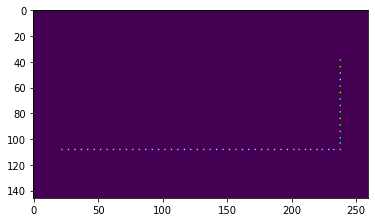

In [118]:
out = np.zeros(test_example.shape)
for (i,j) in my_path:
    out[i,j] = 1
plt.imshow(out)
plt.show()

In [125]:
angle([-1,0], [1,1])/np.pi

0.75

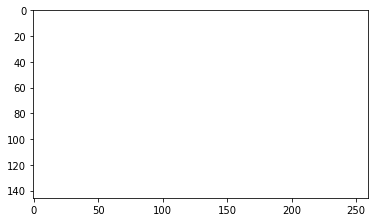

In [110]:
# unit test2: with 90 grad winkel --> not supposed to work with max_angle 3/4, only with 1/4
example2 = np.zeros(test_example.shape)
example2 += np.inf
example2[start_inds[0], start_inds[1]:dest_inds[1]-3] = 1
example2[start_inds[0], dest_inds[1]] = 1
example2[dest_inds[0]:start_inds[0]-3, dest_inds[1]] = 1
plt.imshow(example2)
plt.show()

In [116]:
example2[start_inds[0], dest_inds[1]]

1.0

### Most important testing function to check whether it is correct

In [226]:
shift_dict = {tuple(shifts[i]):i for i in range(len(shifts))}
prev = start_inds
c = test_example[start_inds[0], start_inds[1]] # - 0.3918232239145548 # first angle is wrong --> subtract
path = my_path
for p in range(1, len(path)):
    i,j = path[p] # current node
    shift = path[p] - prev # incoming edge index to the current node --> should have accumulated cost of prev one 
    shift_ind = shift_dict[tuple(shift)]
    prev = path[p]
    ang = 0.5 * angle(path[p]-path[p-1], path[p-1]-path[p-2])/(3*np.pi/4)
    if p==1:
        c-=ang
    cost = 0.5 * test_example[i,j]
    print(round(dists[shift_ind, i,j], 5), "actual",  round(c + ang + cost, 5))
    # print(shift_ind, i,j)
    # print(ang)
    c += ang + cost

0.37187 actual 0.37187
0.50747 actual 0.50747
0.61845 actual 0.61845
0.74796 actual 0.74796
0.86319 actual 0.86319
0.97752 actual 0.97752
1.11762 actual 1.11762
1.25501 actual 1.25501
1.49927 actual 1.3953
1.74356 actual 1.54678
1.89174 actual 1.69496
2.0474 actual 1.85063
2.23788 actual 2.0411
2.39005 actual 2.19327
2.46611 actual 2.26933
2.57752 actual 2.38074
2.7297 actual 2.53292
2.88187 actual 2.68509
3.01123 actual 2.81445
3.16341 actual 2.96663
3.29724 actual 3.10046
3.43836 actual 3.24159
3.54378 actual 3.34701
3.67854 actual 3.48177
3.85069 actual 3.65391
4.03102 actual 3.83424


## Compare to line graph

In [190]:
a = np.zeros((5,5, 5))
a[1,2] = 1
a[:, (1,2)]

SyntaxError: invalid syntax (<ipython-input-190-e7048491a6ca>, line 3)

In [11]:
from power_planner.graphs import *

In [266]:
def run_on_lg(test_example, start_inds, dest_inds, cost_weights):
    instance_corr = np.zeros(test_example.shape)
    instance_corr[dest_inds[0]:start_inds[0]+1, start_inds[1]:dest_inds[1]+1] = 1
    # plt.imshow(instance_corr)
    # plt.colorbar()
    # plt.show()
    graph = LineGraph(
        np.array([test_example]), instance_corr, graphtool=1, verbose=1
    )
    graph.set_edge_costs(["resistance"], cost_weights) # [0.4,1])
    graph.set_shift(min_dist, max_dist, dest_inds-start_inds, 0.5 * np.pi)
    # add vertices
    graph.add_nodes()
    corridor = np.ones(instance_corr.shape) * 0.5  # start with all
    graph.set_corridor(1, corridor, start_inds, dest_inds)
    print("1) set cost rest")
    graph.add_edges()
    print("2) added edges", len(list(graph.graph.edges())))
    print("number of vertices:", len(list(graph.graph.vertices())))

    # weighted sum of all costs
    graph.sum_costs()
    source_v, target_v = graph.add_start_and_dest(start_inds, dest_inds)
    path, path_costs, cost_sum = graph.get_shortest_path(source_v, target_v)
    return np.array(path), np.array(path_costs)

In [267]:
path, path_costs = run_on_lg(test_example, start_inds, dest_inds, [0.1,0.9])

edge costs classes: ['angle', 'resistance']
['angle', 'resistance'] [0.1 0.9]
Added nodes: 265720 in time: 0.02940201759338379
1) set cost rest
n_neighbors: 740
Done adding edges: 2431204
DONE adding 2431204 edges: 4.002562046051025
2) added edges 2431204
number of vertices: 265720
mean costs: [0, 0.3203917633138973]


### Plot both paths

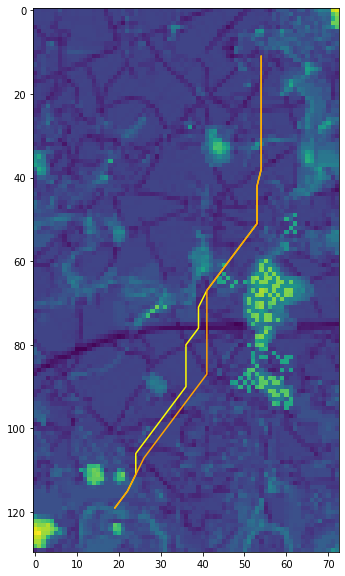

In [472]:
path = np.array(path_ba)
my_path = np.array(path_ab)
plt.figure(figsize=(20,10))
plt.imshow(np.swapaxes(test_example,1,0))
plt.plot(path[:,0], path[:,1],color="yellow")
plt.plot(my_path[:,0], my_path[:,1], color="orange")
plt.show()

### Compare costs

In [194]:
rev_len = len(my_path)
angs = compute_angles_manually(path)
my_angs = compute_angles_manually(my_path)
for p in range(len(path)):
    print(path[p], my_path[p])
    # print(test_example[my_path[p][0], my_path[p][1]])
    i,j = tuple(my_path[p])
    k,l = tuple(path[p])
    print(test_example[k,l], my_path_costs[p], round(test_example[i,j],2), angs[p], my_angs[p])
    # print(round(path_costs[p][1],2), round(test_example[i,j], 2))

[51 19] [52 15]
0.09
[50 23] [51 19]
0.0
[49 27] [50 23]
0.0
[48 31] [49 27]
0.0
[48 36] [48 31]
0.1
[48 41] [48 36]
0.0
[48 46] [48 41]
0.0
[48 51] [48 46]
0.0
[48 56] [48 51]
0.0
[48 61] [48 56]
0.0
[48 66] [48 61]
0.0
[48 70] [48 66]
0.0
[48 75] [48 70]
0.0
[47 79] [48 75]
0.1
[44 83] [47 79]
0.17
[41 87] [44 83]
0.0
[38 91] [41 87]
0.0
[35 95] [38 91]
0.0
[32 99] [35 95]
0.0
[ 29 103] [32 99]
0.0
[ 26 107] [ 29 103]
0.0
[ 23 111] [ 26 107]
0.0
[ 21 115] [ 23 111]
0.08
[ 19 119] [ 21 115]
0.0
[52 19] [53 15]
0.0
[51 23] [52 19]
0.0
[50 27] [51 23]
0.0
[49 31] [50 27]
0.0
[49 36] [49 31]
0.1
[49 41] [49 36]
0.0
[49 46] [49 41]
0.0
[49 51] [49 46]
0.0
[49 56] [49 51]
0.0
[49 60] [49 56]
0.0
[49 65] [49 60]
0.0
[49 70] [49 65]
0.0
[49 75] [49 70]
0.0
[47 79] [49 75]
0.2
[44 83] [47 79]
0.08
[41 87] [44 83]
0.0
[38 91] [41 87]
0.0
[35 95] [38 91]
0.0
[32 99] [35 95]
0.0
[ 29 103] [32 99]
0.0
[ 26 107] [ 29 103]
0.0
[ 23 111] [ 26 107]
0.0
[ 21 115] [ 23 111]
0.08
[ 19 119] [ 21 115]
0.0

In [195]:
print(np.sum(path_costs[1:-1,1]), np.sum(my_path_costs[1:-1]))

6.03894887894087 6.144842312241731


In [196]:
print(np.sum(angs), np.sum(my_angs))

0.5399999999999999 0.45999999999999996


In [197]:
print(0.5*np.sum(angs)+ 0.5*np.sum(path_costs[:,1]), 0.5*np.sum(my_angs)+ 0.5*np.sum(my_path_costs))

3.6098662027843322 3.6087611039244445


In [26]:
len(my_path), len(path)

(50, 50)

## K shortest paths

### Best path

In [278]:
best_path = [dest_inds]
best_costs = [np.min(dists[:, dest_inds[0], dest_inds[1]])]
min_shift = np.argmin(dists[:, dest_inds[0], dest_inds[1]])
curr_point = dest_inds
while np.any(curr_point - start_inds):
    new_point = curr_point - shifts[int(min_shift)]
    min_shift = dists_argmin[int(min_shift), curr_point[0], curr_point[1]]
    
    best_path.append(new_point)
    curr_point = new_point
    best_costs.append(dists[int(min_shift), curr_point[0], curr_point[1]])
    
        
# Todo: most different and most similar costs criteria
# backtrack from dest_ind and then divide further / divide on different points on the path

In [302]:
best_path = np.array(best_path)

In [ ]:
# def recursive_paths()

In [353]:
N_EXPLORE = 3 # explore 3 paths for each vertex on the path
angle_weight=0.1
collected_paths = []
collected_costs = []
for k in range(len(best_path)-1):
    i,j = best_path[k]
    if k>0:
        angles_for_shift = [angle(shifts[m], best_path[k-1]-best_path[k]) for m in range(len(shifts))] # k-1: dest, k: one before dest 
    else:
        angles_for_shift = [1 for _ in range(len(shifts))]
    angles_for_shift = np.array(angles_for_shift)/(3*np.pi/4)
    angles_for_shift[angles_for_shift>1] = np.inf
    # get the new three best dependent on angle and minimum accumilated cost
    three_best = np.argsort(dists[:,i,j] + angle_weight * np.array(angles_for_shift))[7:N_EXPLORE+8] # [:N_EXPLORE+1]
    # three_best = np.argsort(dists[:,i,j])[:N_EXPLORE]
    # iterate over the x best ones for this part of the path
    for div in range(1, N_EXPLORE+1):
        expl_path = []
        expl_cost = best_costs[0] - best_costs[k] - angle_weight * angles_for_shift[three_best[0]]
        # add the points on the path so far (starting from dest)
        for l in range(k+1): # for k = 0, only append the dest_inds
            expl_path.append(best_path[l])
        min_shift = three_best[div]
        expl_cost = expl_cost + dists[int(min_shift),i,j] + angle_weight*angles_for_shift[min_shift]
        curr_point = best_path[k]
        # add the new part of the path
        while np.any(curr_point - start_inds):
            # min_dist = np.argmin(dists[:, curr_point[0], curr_point[1]])
            new_point = curr_point - shifts[int(min_shift)]
            min_shift = dists_argmin[int(min_shift), curr_point[0], curr_point[1]]
            if dists[int(min_shift), curr_point[0], curr_point[1]] < np.inf:
                expl_costs.append(dists[int(min_shift), curr_point[0], curr_point[1]])
            expl_path.append(new_point)
            curr_point = new_point
    collected_paths.append(expl_path)
    collected_costs.append(expl_cost)
# Todo: most different and most similar costs criteria
# backtrack from dest_ind and then divide further / divide on different points on the path

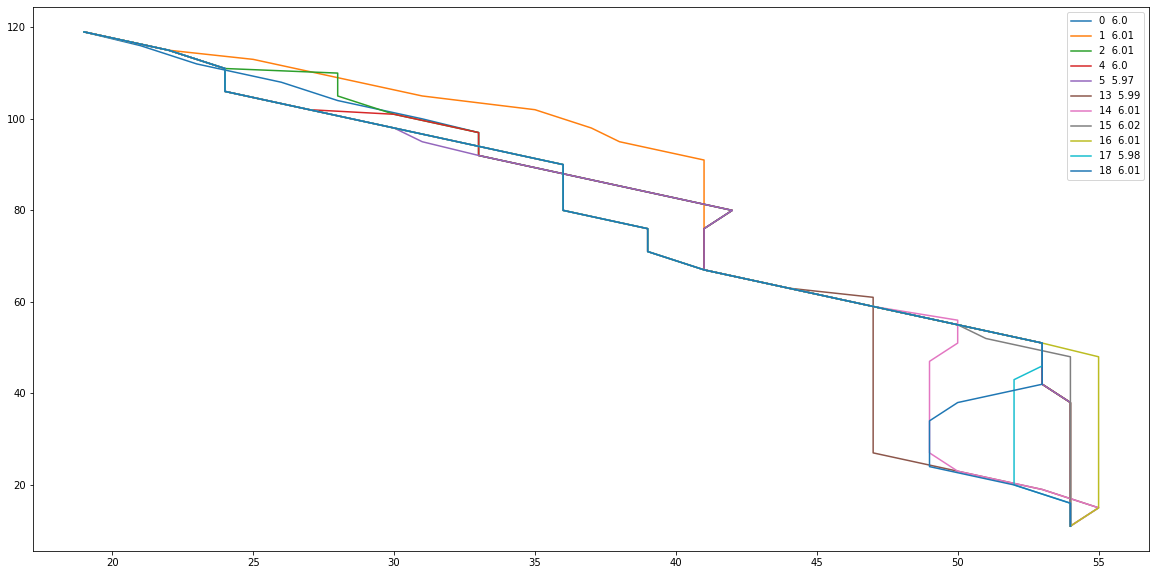

In [358]:
plt.figure(figsize=(20,10))
for i, path_points in enumerate(collected_paths): # [3:4]):
    # print(path_points)
    co = round(collected_costs[i], 2) # np.sum(collected_costs[i])
    if co < best_costs[0] + best_costs[0]*0.03: # take the ones that have only + x % costs
        path_points = np.array(path_points)
        plt.plot(path_points[:,0], path_points[:,1], label = str(i)+"  "+str(co))
plt.legend()    
plt.show()

## Path passing through point C

In [403]:
path_ab

[array([ 19, 119]),
 array([ 22, 115]),
 array([ 24, 111]),
 array([ 24, 106]),
 array([ 27, 102]),
 array([30, 98]),
 array([33, 94]),
 array([36, 90]),
 array([36, 85]),
 array([36, 80]),
 array([39, 76]),
 array([39, 71]),
 array([41, 67]),
 array([44, 63]),
 array([47, 59]),
 array([50, 55]),
 array([53, 51]),
 array([53, 46]),
 array([53, 42]),
 array([54, 38]),
 array([54, 34]),
 array([54, 29]),
 array([54, 24]),
 array([54, 20]),
 array([54, 16]),
 array([54, 11])]

3.643258194197215
2.608619159173859


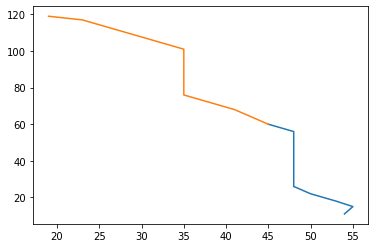

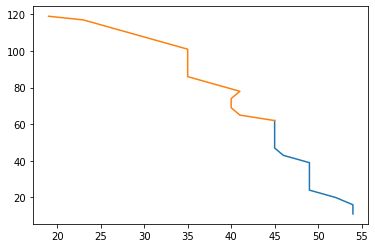

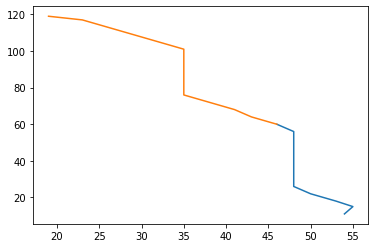

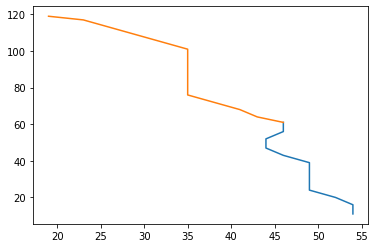

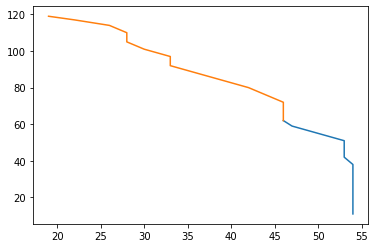

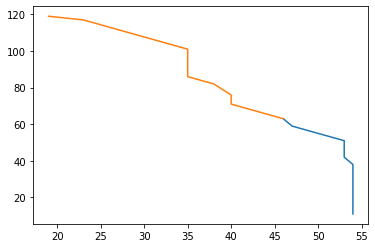

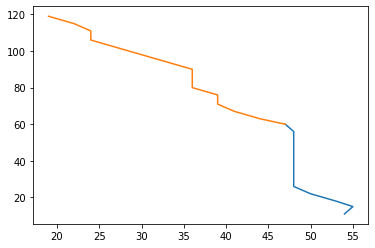

KeyboardInterrupt: 

In [417]:
c = np.array([40, 80])
print(np.min(dists_ab[:, c[0], c[1]]))
print(np.min(dists_ba[:, c[0], c[1]]))

def get_sp(dists, dists_argmin, start_inds, dest_inds, shifts):
    if not np.any(dists[:, dest_inds[0], dest_inds[1]] < np.inf):
        raise RuntimeWarning("empty path")
    curr_point = dest_inds
    my_path = [dest_inds]
    min_shift = np.argmin(dists[:, dest_inds[0], dest_inds[1]])
    while np.any(curr_point - start_inds):
        # print(curr_point)
        new_point = curr_point - shifts[int(min_shift)]
        min_shift = dists_argmin[int(min_shift), curr_point[0], curr_point[1]]
        my_path.append(new_point)
        curr_point = new_point
    return np.asarray(my_path)

def best_in_window(w_xmin, w_xmax, w_ymin, w_ymax, dists_ab, dists_ba, dest_inds, test_example, margin=0.05):
    """
    margin: percent that it's allowed to be higher than average
    """
    possible_cs = []
    for x in range(w_xmin, w_xmax+1, 1):
        for y in range(w_ymin, w_ymax+1, 1):
            # todo here: take into account angle directly
            added_costs = np.min(dists_ab[:, x, y]) +  np.min(dists_ba[:, x, y]) - test_example[x,y]
            opt = np.min(dists_ab[:, dest_inds[0], dest_inds[1]])
            # print(added_costs, opt)
            if added_costs < opt + margin*opt:
                possible_cs.append(np.array([x,y]))
    for c in possible_cs:
        path_ac = get_sp(dists_ab, dists_argmin_ab, start_inds, c, shifts_ab)
        path_cb = get_sp(dists_ba, dists_argmin_ba, dest_inds, c, shifts_ba)
        plt.plot(path_ac[:,0], path_ac[:,1])
        plt.plot(path_cb[:,0], path_cb[:,1])
        plt.show()

best_in_window(45, 48, 60, 63, dists_ab, dists_ba, dest_inds, test_example)

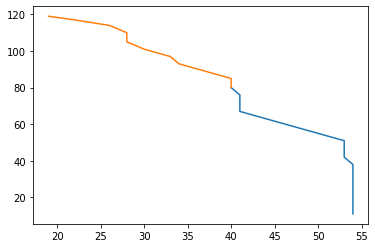

In [399]:
# minimum incoming edge cost --> this is the edge we take
# need to add it up and add angle inbetween
# TODO: more elaborate approach (minimum of angle from both directions) --> would need to try all combinations of dists + angle --> len(shifts)^2 iters
print(np.min(dists_ab[:, c[0], c[1]]))
print(np.min(dists_ba[:, c[0], c[1]]))
plt.plot(path_ac[:,0], path_ac[:,1])
plt.plot(path_cb[:,0], path_cb[:,1])
plt.show()

In [387]:
path_ac

[array([54, 11])]

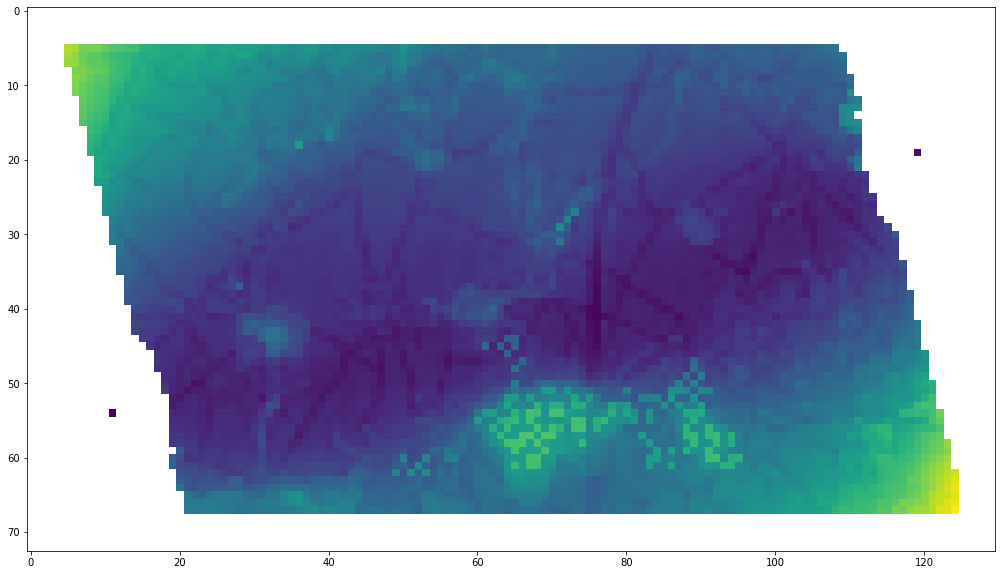

In [381]:
# Todo: find minimums in that or so 
plt.figure(figsize=(20,10))
plt.imshow(np.mean(dists_ab, axis=0) + np.mean(dists_ba, axis=0))
plt.show()

## Random shit

In [212]:
%timeit 2*2


12.1 ns ± 0.0427 ns per loop (mean ± std. dev. of 7 runs, 100000000 loops each)


In [ ]:
# old versions from package
    def get_path_from_dists(self, start_inds, dest_inds):
        curr_point = dest_inds
        path = [dest_inds]
        path_costs = [self.instance[dest_inds[0], dest_inds[1]]]
        # print(test_example[dest_inds[0], dest_inds[1]])
        while np.any(curr_point - start_inds):
            min_shift = np.argmin(self.dists[:, curr_point[0], curr_point[1]])
            new_point = curr_point - self.shifts[min_shift]
            path.append(new_point)
            # print(new_point)
            # print(test_example[new_point[0], new_point[1]])
            path_costs.append(self.instance[new_point[0], new_point[1]])
            curr_point = new_point
        path.append(curr_point)

        path = np.flip(np.asarray(path), axis=0)
        path_costs = np.flip(np.asarray(path_costs), axis=0)

        return path, path_costs

In [ ]:
# Test functions for correctness
# FUNCTION 1
path = my_path
costs_start = test_example[start_inds[0],start_inds[1]]
for p in range(len(path)-2):
    (i,j) = path[p]
    k,l = path[p+1]
    print(i,j)
    # print(dists[:, i,j])
    print(round(np.min(dists[:, i,j]),3))
    print("angle", 0.5* angle(path[p+1]-path[p], path[p+2]-path[p+1])/(3*np.pi/4))
    print("costs", round(0.5* test_example[k,l],2))
    costs_start += 0.5* test_example[k,l] + 0.5* angle(path[p+1]-path[p], path[p+2]-path[p+1])/(3*np.pi/4)
    print(round(costs_start,2))
    print("-----------")
    
# FUNCTION 2 
curr_point = dest_inds
some_path = [dest_inds]
count = len(path)-2
# print(test_example[dest_inds[0], dest_inds[1]])
while np.any(curr_point - start_inds):
    # print(dists[:, curr_point[0], curr_point[1]])
    min_shift = np.argmin(dists[:, curr_point[0], curr_point[1]])
    new_point = curr_point - shifts[min_shift]
    print("--------------------")
    print(curr_point)
    print(np.min(dists[:, curr_point[0], curr_point[1]]))
    print("shift", shifts[min_shift])
    some_path.append(new_point)
    
    i,j = curr_point
    print("costs currpoint", test_example[i,j]*0.5)
    curr_point = new_point
    if np.any(curr_point!=path[count]):
        print(path[count])
    count-= 1
    k,l = path[count]
    # print("costs actual", test_example[k,l]*0.5)